# Introduction
* Hello, my name is Geary
- This is a project exporing and modeling temperatures for New York State 
- - Captured by Berkly Earth and Hosted by Kaggle

## Project Objective 
> Document code, process data (through entire pipeline), and articulate key findings and takeways
* Create modules that faciliate project repeatability, as well as final report readability
> Ask/Answer exploratory questions of data and attributes to understand changes in Temperature  
* Utilize charts and statistical tests
> Construct models to predict temperature</br> 
* Make recommendations  

## Project Business Goals
> Construct ML Forecasting models that accurately predicts `AverageTemperature`  
> Find relationships for `AverageTemperature`  
> Deliver report that the data science team can read through and replicate  
> Share steps were taken, why and what the outcome was.  
> Make recommendations on what works or doesn't work in predicting `AverageTemperature`

### Executive Summary
* Relied on clustering for bulk of feature differientation to predict `logerror`
* Feature sets informed by clustering performed best on model through validation phase
* Model gain on predictive performance vs. baseline prediction was minimal on test set

# Import Section

In [1]:
#main imports
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import acquire
import os
import scipy
import statsmodels.api as sm

#partial imports
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from statsmodels.tsa.api import Holt


In [2]:
def append_eval_df(model_type, target_var):
    ''' 
    throw in model_type and target_var to get an appended dataframe with rmse result on validate
    '''
    rmse = round((mean_squared_error(validate[target_var], yhat_df[target_var]))**.5, 0)
    d = {'model_type': [model_type], 'target_var': [target_var], 'validate_rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df,d], axis=0)

# plot and evaluate 
def plot_and_eval(target_var):
    ''' 
    get the evaluation of the models performance and plot the results
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[1970:][target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(f'{eval_df["model_type"][-1:][0]},{target_var}')
    rmse = round((mean_squared_error(validate[target_var], yhat_df[target_var]))**.5, 0)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


def static_subcat_2samp_Ttest(train, num = "AverageTemperature", cat = "Decade", cat_1 = 1800, cat_2 = 1970, alpha = .025):
    ''' 
    static 2sample ttest for testing sub categories of a feature
    no input required if used for this purpose
    tests for variance and passes flag to ttest, plots the density of the results and a barchart of the two subcats
    '''

    H0 = f"{num} of {cat}{cat_1} are greater than or equal to {num} of {cat}{cat_2}"
    Ha = f"{num} of {cat} is less than and not equal to {num} of other {cat}"
    print("-----------------------------")

    #compare variances to know how to run the test
    stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
    stat,pval
    if pval > 0.05:
        equal_var_flag = True
        print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
    else:
        equal_var_flag = False
        print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))

    #tests the two samples in a ttest and deliver results
    t, p = stats.ttest_ind( train[train[cat] == cat_2][num], train[train[cat] == cat_1][num], equal_var = equal_var_flag )
    if p > alpha or t < 0:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


    #creates plotting the feature
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=train[(train.Decade==1800) | (train.Decade==1970)], x="Decade", y="AverageTemperature",
        linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),)
    plt.axhline(y=train.AverageTemperature.mean(),label=f"AverageTemperature Mean {round(train.AverageTemperature.mean(),3)}",color="blue")
    plt.legend()
    plt.title("Decades in relation to AverageTemperature")
    plt.show()

def explore_split_time_series(df,target="",train_year="1980",validate_year="2000",plot=True):
    ''' 
    input dataframe, target(as string), and train size(as float)
    splits based on size, seperates out into y(series) and train df (includes target)
    plots a few examples
    returns train, test,y_train,y_test
    '''

    train = df.loc[:train_year] # everything up (not including) to the test_start_index
    validate = df[train_year:validate_year]
    test = df[validate_year:] # everything from the test_start_index to the end

    y_train = train[target]
    print(train.shape,"train shape")

    y_validate = validate[target]
    print(validate.shape,"validate shape")
    
    y_test = test[target]
    print(test.shape,"test shape")

    if plot == True:
        plt.plot(train.index, train[target])
        plt.plot(validate.index, validate[target])
        plt.plot(test.index, test[target])
        plt.title(f"{target} over time")
        plt.ylabel(f"{target}")
        plt.xlabel("Time")
        plt.show()

        y_train.plot.hist()
        plt.title(f"{target} distribution (train)")
        plt.xlabel(f"{target}")
        plt.ylabel("Count")
        plt.show()

    return train, validate, test, y_train, y_validate, y_test



def explore_target_mean_time_series(y_train,target):
    ''' 
    input y_train and target
    plots out group plots
    '''
    y_train.resample('W').mean().plot(alpha=.25, label='Weekly')
    y_train.resample('M').mean().plot(alpha =.5 , label='Montly')
    y_train.resample('Y').mean().plot(alpha =.75 ,label='Yearly')
    y_train.resample('10Y').mean().plot(label='Decade')
    plt.title(f"{target} over time")
    plt.legend()
    plt.show()


    y_train.groupby(y_train.index.day_name()).mean().\
        sort_values().plot.bar(width=.9, 
                               ec='black',
                               title=f'Average {target} by Weekday', 
                               xlabel='Weekday', 
                               ylabel=target)
    plt.xticks(rotation=0)

    ax = y_train.groupby(y_train.index.isocalendar().week).mean().plot.bar(width=.9, ec='black')
    plt.xticks(rotation=0)
    ax.set(title=f'Average {target} by Week', xlabel='Week', ylabel=target)
    plt.show()

    ax = y_train.groupby(y_train.index.month).mean().plot.bar(width=.9, ec='black')
    plt.xticks(rotation=0)
    ax.set(title=f'Average {target} by Month', xlabel='Month', ylabel=target)
    plt.show()

    ax = y_train.groupby(y_train.index.year).mean().plot.bar(width=.9, ec='black')
    plt.xticks(rotation=0)
    ax.set(title=f'Average {target} by Year', xlabel='Year', ylabel=target)
    plt.show()

    ax = y_train.groupby((y_train.index.year//10)*10).mean().plot.bar(width=.9, ec='black')
    plt.xticks(rotation=0)
    ax.set(title=f'Average {target} by Decade', xlabel='Decade', ylabel=target)
    plt.show()

    None


def explore_target_diff_time_series(y_train,target):
    ''' 
    input y_train and target
    prints out a few plots with diffent time spacing
    '''

    #y_train.resample('M').mean().diff().plot(title=f'Average change in {target}',label="Month to Month")
    y_train.resample('Y').mean().diff().plot(title=f'Average change in {target}',label="Year to Year")
    y_train.resample('10Y').mean().diff().plot(title=f'Average change in {target}',label="Decade to Decade")
    plt.xlabel("Time")
    plt.ylabel(f"{target}")
    plt.legend()

    y_train.groupby([((y_train.index.year//10)*10), y_train.index.month]).mean().unstack(0).plot(title='Seasonal Plot',ylabel=f"{target}")
    table = y_train.groupby([((y_train.index.year//10)*10), y_train.index.month]).mean().unstack()

    fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
    for ax, (month, subset) in zip(axs, table.iteritems()):
        subset.plot(ax=ax, title=month)
        ax.hlines(subset.mean(), *ax.get_xlim())
        ax.set(xlabel='Date',ylabel=f"{target}")

    fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
    fig.subplots_adjust(wspace=0)
    plt.show()
    None

def explore_target_yearly_time_series(train,target,year_grouping=1,corr_shift=-1,):
    ''' 
    input train dataframe(needs index as datetime) and target(as string), additional arguements optional
    makes a correlation plot, correlation lag plot, and two decomp plots
    creates a decomp dataframe
    returns the decomp df
    '''
    #makes a correlation with a shift of -1 unless otherwise specified
    yearly = train.resample(f'{year_grouping}A').mean()
    yearly[f'{year_grouping}Year {corr_shift*-1} Difference'] = yearly[target].shift(corr_shift)
    yearly = yearly.rename(columns={target: 'This Year'})
    yearly.plot.scatter(x='This Year', y=f'{year_grouping}Year {corr_shift*-1} Difference')
    plt.title(f"This {year_grouping}Year compared with {corr_shift*-1} {year_grouping}Year Difference for {target}")
    plt.show()

    # plots correlation over changing lag
    pd.plotting.autocorrelation_plot(train[target].resample(f'{year_grouping}A').mean())
    plt.title(f"Correlation of {target} over different {year_grouping}Yearly Lags")
    plt.show()

    #creates dataframe using seasonal decompose to produce trend season and residual plots
    y_train_temp = train[target].resample(f'{year_grouping}A').mean()
    result = sm.tsa.seasonal_decompose(y_train_temp)
    decomposition = pd.DataFrame({f'{year_grouping}y': result.observed,
                                'trend': result.trend,
                                'seasonal': result.seasonal,
                                'resid': result.resid,})
    #plots the results
    result.plot()
    plt.xlabel("Time")
    plt.ylabel(f"{target}")
    plt.show()

    decomposition.iloc[:, 1:].plot()
    plt.ylabel(f"{target} Compared")
    plt.title("Comparison - Trends (aggregated)")
    plt.show()

    decomposition.head()
    return decomposition

In [3]:
#get data by state
temp_state = pd.read_csv('GlobalLandTemperaturesByState.csv')

#cleaning and setting to New York, most missing is long ago
ny_df = temp_state[temp_state.State == "New York"].dropna()

#setting variable
target1="AverageTemperature"
target2="AverageTemperatureUncertainty"

#moving to F degrees from C degrees
ny_df[target1] = ny_df[target1] * 1.8 + 32
ny_df[target2] = ny_df[target2] * 1.8
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3119 entries, 372822 to 376060
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             3119 non-null   object 
 1   AverageTemperature             3119 non-null   float64
 2   AverageTemperatureUncertainty  3119 non-null   float64
 3   State                          3119 non-null   object 
 4   Country                        3119 non-null   object 
dtypes: float64(2), object(3)
memory usage: 146.2+ KB


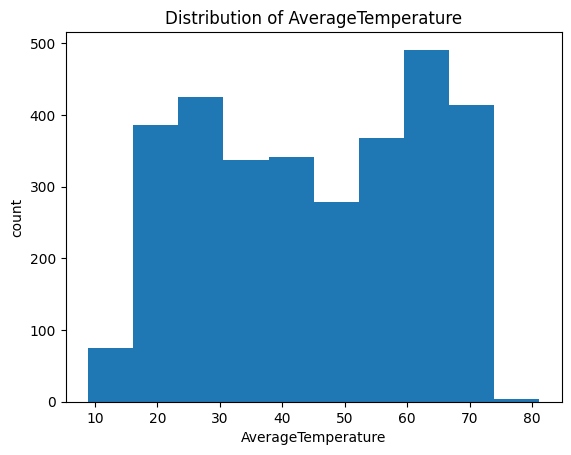

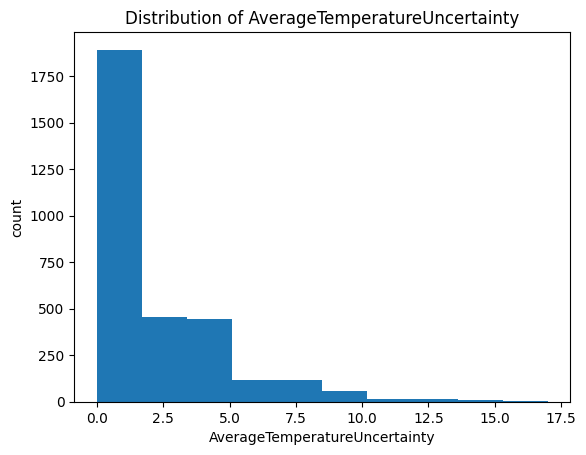

In [4]:
#plots some distributions for review
plt.hist(x=ny_df[target1])
plt.xlabel(f"{target1}")
plt.ylabel("count")
plt.title(f"Distribution of {target1}")
plt.show()

plt.hist(x=ny_df[target2].astype(int))
plt.xlabel(f"{target2}")
plt.ylabel("count")
plt.title(f"Distribution of {target2}")
plt.show()


uncertainty was reduced over time to create the high confidence of today

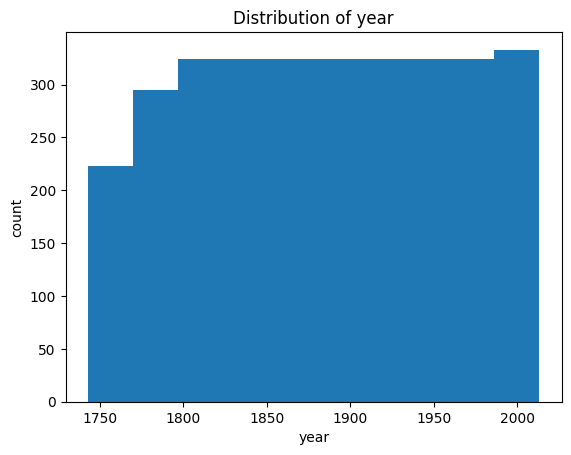

,AverageTemperature,AverageTemperatureUncertainty,State,Country,month,year,Decade
Date_Time,,,,,,,
1743-11-01,34.0538,3.8250,New York,United States,November,1743,1740
1744-04-01,45.1796,4.5900,New York,United States,April,1744,1740
1744-05-01,56.5862,3.6702,New York,United States,May,1744,1740
1744-06-01,66.9002,3.7296,New York,United States,June,1744,1740
1744-07-01,68.7434,3.5874,New York,United States,July,1744,1740
...,...,...,...,...,...,...,...
2013-05-01,58.2638,0.3870,New York,United States,May,2013,2010
2013-06-01,65.4314,0.3060,New York,United States,June,2013,2010
2013-07-01,72.6080,0.3132,New York,United States,July,2013,2010


In [5]:
#changes data to datetime and creates features from it
ny_df.dt = ny_df.dt.str.strip()
ny_df.dt = pd.to_datetime(ny_df.dt)
ny_df.rename(columns={"dt": "Date_Time"},inplace=True)
ny_df = ny_df.set_index("Date_Time").sort_index()    
ny_df["month"] = ny_df.index.month_name()
ny_df["year"] = ny_df.index.year

ny_df["Decade"] = ((ny_df["year"]//10)*10)

plt.hist(x=ny_df["year"].astype(int))
plt.xlabel("year")
plt.ylabel("count")
plt.title(f"Distribution of year")
plt.show()
ny_df

looks about right, before 1800s was lacking info

In [6]:
##cleaning data for consistency in counts per year, seeing weird data before 1800s, dropping it
for i in ny_df.year.unique():
    if len(ny_df[ny_df["year"] == i]) != 12:
        ny_df = ny_df[ny_df["year"] != i]
    elif i < 1800:
        ny_df = ny_df[ny_df["year"] != i]

ny_df

,AverageTemperature,AverageTemperatureUncertainty,State,Country,month,year,Decade
Date_Time,,,,,,,
1800-01-01,20.1398,4.4100,New York,United States,January,1800,1800
1800-02-01,21.2792,7.2378,New York,United States,February,1800,1800
1800-03-01,29.2154,7.0452,New York,United States,March,1800,1800
1800-04-01,46.2362,4.0032,New York,United States,April,1800,1800
1800-05-01,54.7322,3.7566,New York,United States,May,1800,1800
...,...,...,...,...,...,...,...
2012-08-01,69.9872,0.5166,New York,United States,August,2012,2010
2012-09-01,61.1258,0.3510,New York,United States,September,2012,2010
2012-10-01,51.6416,0.4212,New York,United States,October,2012,2010


(2172, 2) train shape
(252, 2) validate shape
(156, 2) test shape


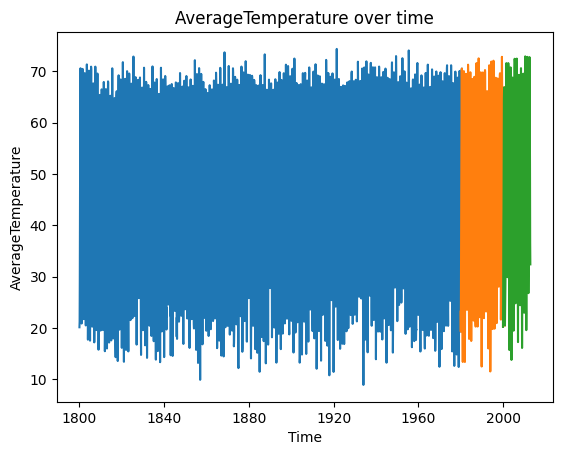

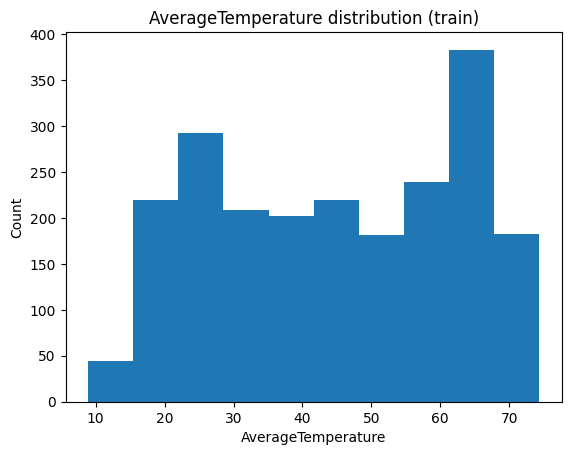

In [7]:
## splits based on arbitarily decided years and returns dataframes/series to use, plots out result of split and distribution of target for train
train, validate, test, y_train, y_validate, y_test = \
    explore_split_time_series(ny_df[["AverageTemperature","Decade"]],target1)

## Exploration Questions 
* Includes visualizations and statistical tests

### Guidance - Initial Questions
* Graph out temperature over time to see variations
* Look for trends or outliers

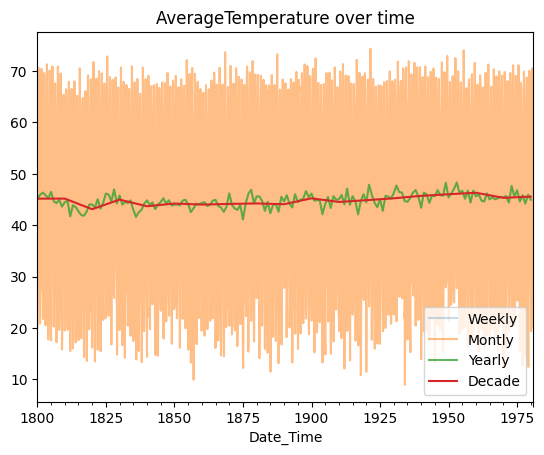

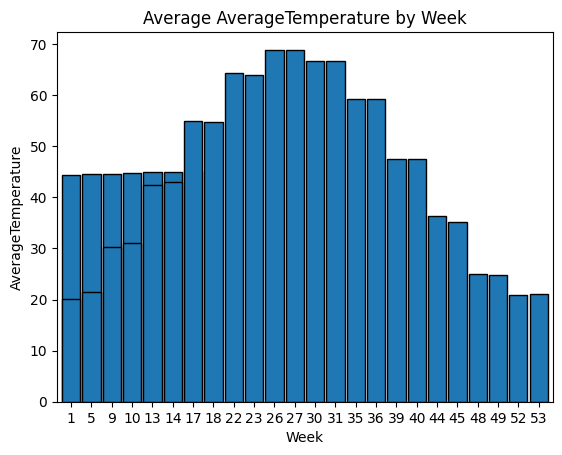

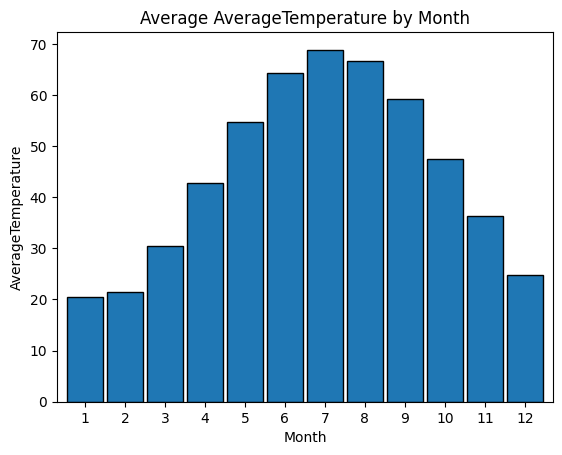

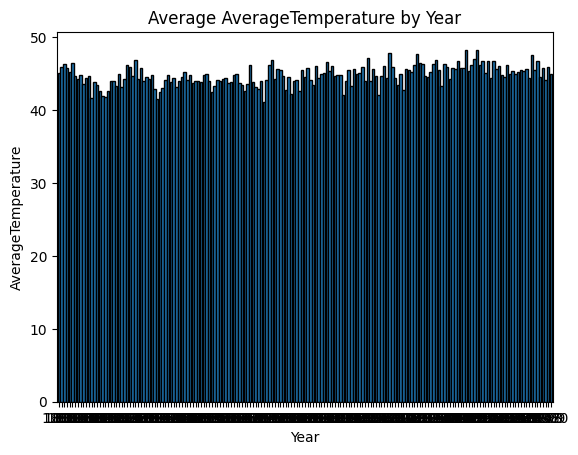

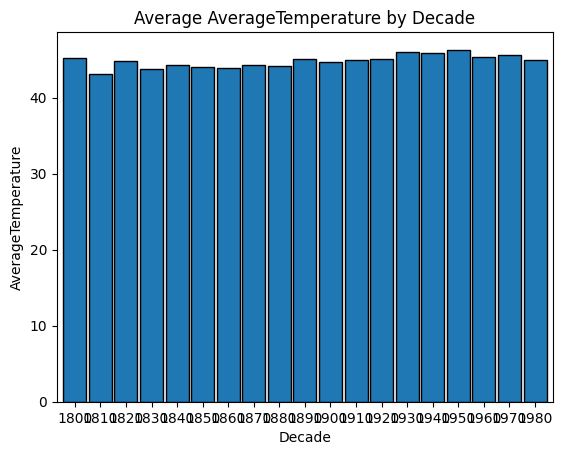

In [8]:
## tailed function to call on time series to explore in an inital way to help look for trends or outliers to chase
explore_target_mean_time_series(y_train,target1)

#### Takeaways
* occasional hot and cold years (possibly in cycles)
* weather ramps up in summer and winds down in winter (expected)
* weekly and month are too granular

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_62357/1595070935.py:166: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ax, (month, subset) in zip(axs, table.iteritems()):


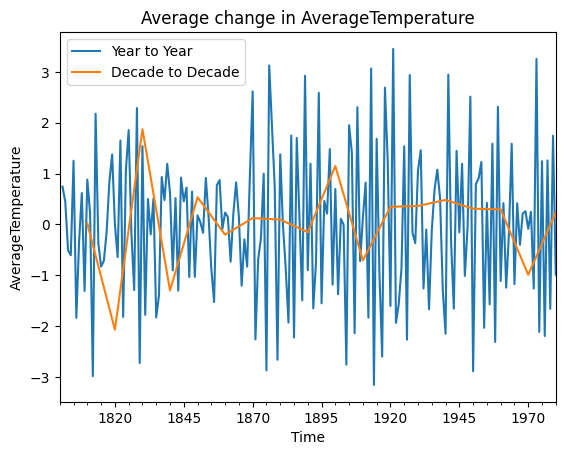

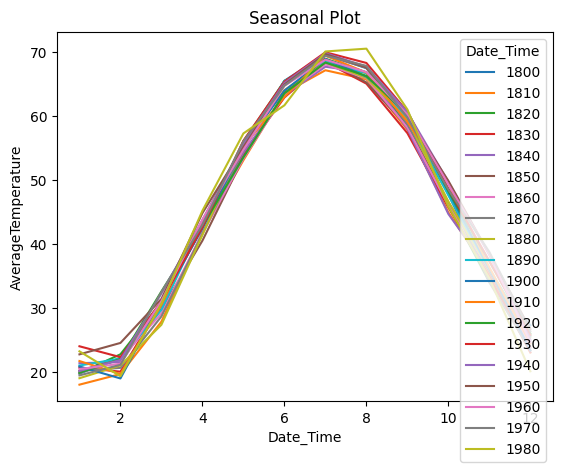

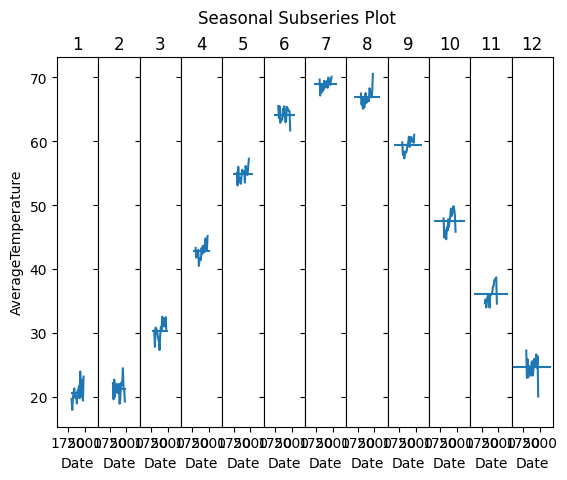

In [9]:
# based on takeway above, tailored to help see trends in change looking at year, decade, and seasonal/month
explore_target_diff_time_series(y_train,target1)

#### Takeaway
* General seasonal trends, will need to ask specific questions to isolate out any information  
* pre 1870s saw big swings in decade but not to the same volitility after  
* post 1870s saw bigger swings in yearly changes


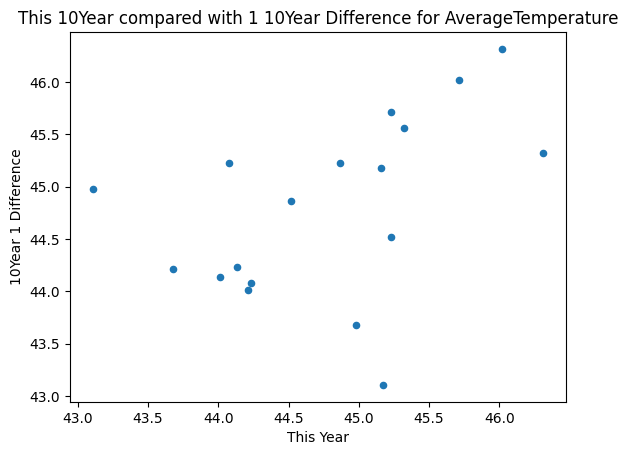

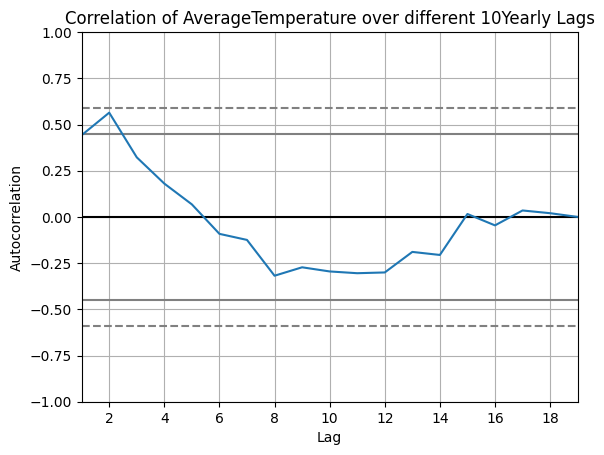

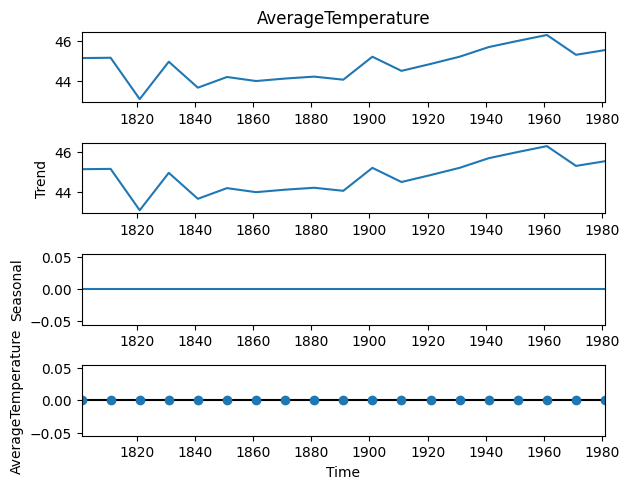

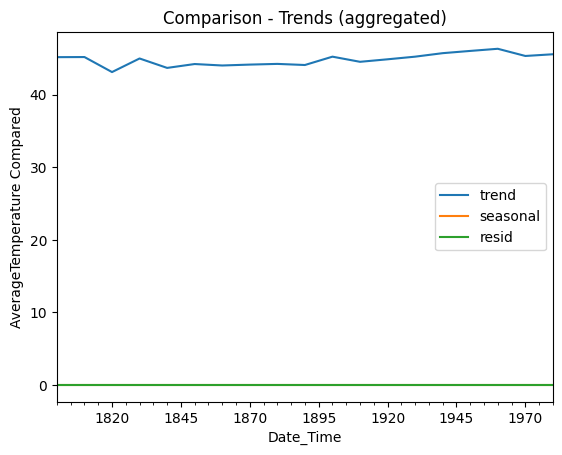

,10y,trend,seasonal,resid
Date_Time,,,,
1800-12-31,45.159650,45.159650,0.0,0.0
1810-12-31,45.175445,45.175445,0.0,0.0
1820-12-31,43.105460,43.105460,0.0,0.0
1830-12-31,44.977175,44.977175,0.0,0.0
1840-12-31,43.678535,43.678535,0.0,0.0
1850-12-31,44.212550,44.212550,0.0,0.0
1860-12-31,44.010800,44.010800,0.0,0.0
1870-12-31,44.135285,44.135285,0.0,0.0
1880-12-31,44.230880,44.230880,0.0,0.0


In [10]:
# calls function at the start that plots our relationship in difference of the years, decomposes and returns trends
explore_target_yearly_time_series(train,target1,year_grouping=10,corr_shift=-1,)

> ### Initial Explore takeway:
- We see in our decomposition plot that there is a trend starting around the 1900s that the temperature is slighlyt increasing (< 2 F-deg)
- Interesting the variation is the most with the lower temperatures

### Question 1 -  Does the temperature of (1801-1810) have a correlation with tempeature in (1971-1980) (arbitrarily chosen)
> ${H_0}$: There is not a correlation in the decades `1800s` and `1970s`  
> ${H_a}$: There is a correlation in the decades `1800s` and `1970s`  
> ${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis.

Results of SpearmanR (r = 0.971|p = 0.0)


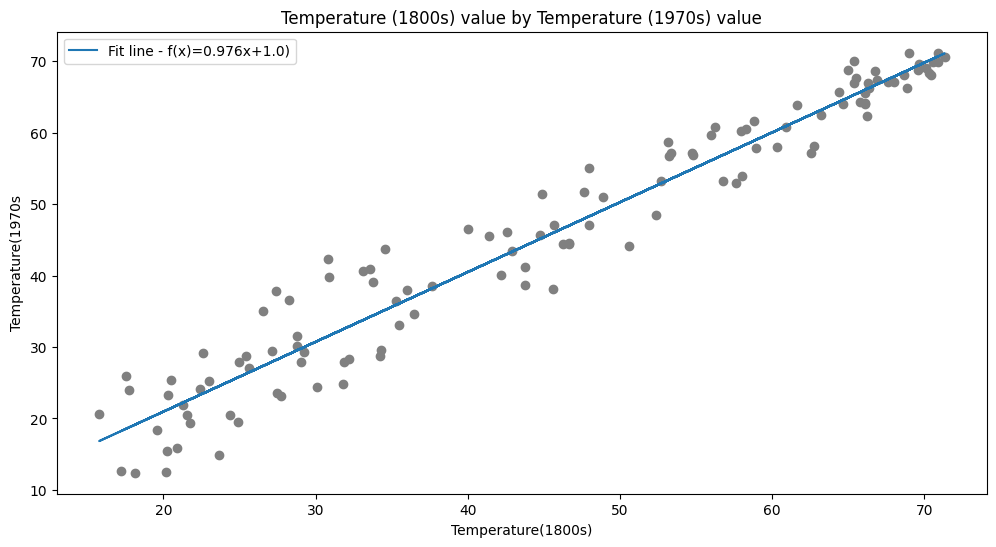

In [11]:
## assigns two variables to be used in the scatterplot, which has a polyline(1) plotted over it,
## Also runs a SpearmanR correlation test and returns the values

#set variables
x,y = train[(((train.index.year//10)*10) == 1800)][target1] , train[(((train.index.year//10)*10) == 1970)][target1]

#test and results
r, p = stats.spearmanr(x,y)
print(f"Results of SpearmanR (r = {round(r,3)}|p = {round(p,3)})")

#plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, "o",color="grey")
m,b = np.polyfit(x,y,1)
plt.plot(x,m*x+b,label=f"Fit line - f(x)={round(m,3)}x+{round(b,0)})")
plt.xlabel("Temperature(1800s)"), plt.ylabel("Temperature(1970s")
plt.legend(), plt.title(f"Temperature (1800s) value by Temperature (1970s) value")
plt.show()

> #### Q1 takeway:
- High correlation with high confidence that these temperatures sets are related
- Interesting the variation is the Highest with the lower temperatures

### Question 2 - On average, has the temperture increased in the 1970s compared to the 1800s?


#### Statistical Testing
${H_0}$: The mean in `1800s` temperatures has no significant difference or it is greater than `1970s` temperatures  
${H_a}$: the mean in `1800s` temperatures has significant difference and it is greater than  `1970s` temperatures    
${\alpha}$: .025

> Result: Failure to reject our null hypothesis.   

-----------------------------
we can accept that there are equal variance in these two groups with 0.88 certainty Flag=T stat=0.02197, p=0.88230

 We fail to reject the null hypothesis ( AverageTemperature of Decade1800 are greater than or equal to AverageTemperature of Decade1970 ) t=0.15881, p=0.87396


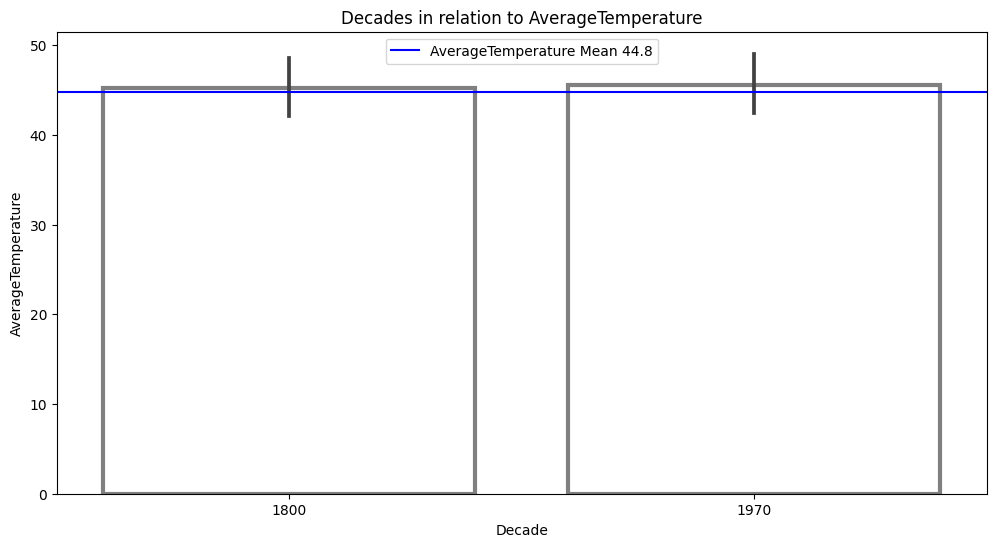

In [12]:
#calls custom function from above written for this question (does levene test for variance, passes flag to 2sample ttest (1 sided)
# returns results of ttest and plots distribution and barchart of the 2 subcategories tested for the target variable)
static_subcat_2samp_Ttest(train)

> #### Q2 takeway:
- While there was an slight increase in the mean (t = .158) between the two samples; it was not significant enought to pass our confidence threshould (alpha = .025)

## Overall Exploration Takeaways
* Not huge difference in temperature 170 years later. 
* A small general trend is showing an increase over the recent years, but that trend is less than 2 degs F 
* Cycles of hot and cold with the occasional odd ball year could give my choice decades to compare a false sense of confidence in no significant difference

* I could look at years on a larger scale (25 year bins) to compare larger groups and capture the recent temperature increase

# Modeling

In [13]:
train0 = train.copy()

AverageTemperature -- RMSE: 31


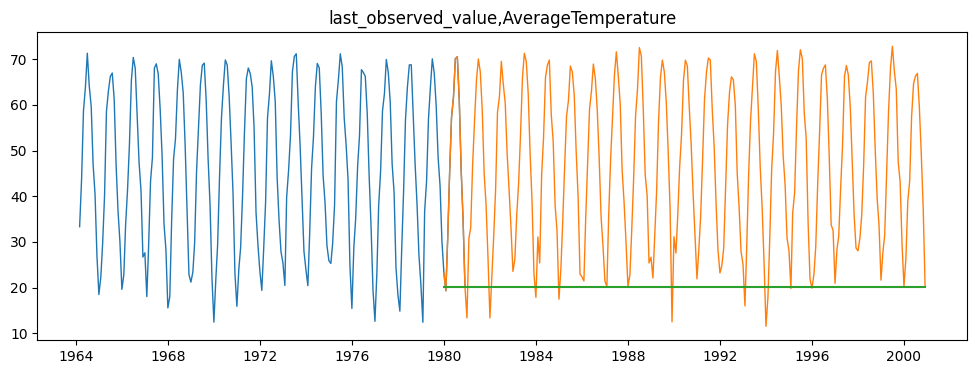

AverageTemperature -- RMSE: 17


/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_62357/1595070935.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.title(f'{eval_df["model_type"][-1:][0]},{target_var}')


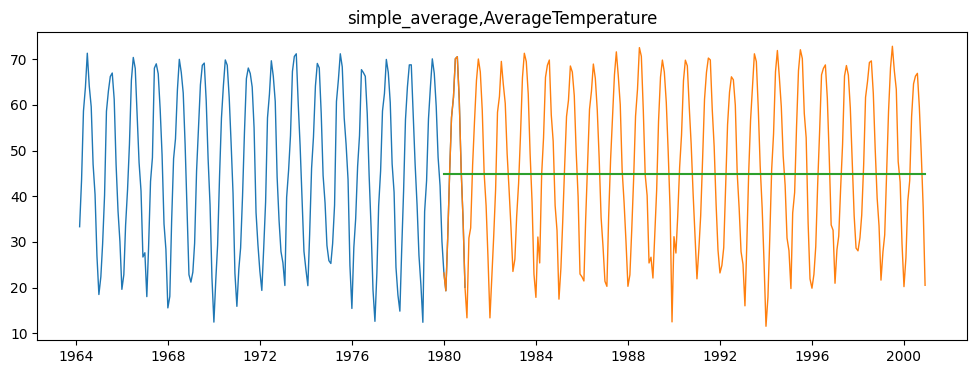

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_62357/1595070935.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.title(f'{eval_df["model_type"][-1:][0]},{target_var}')


AverageTemperature -- RMSE: 17


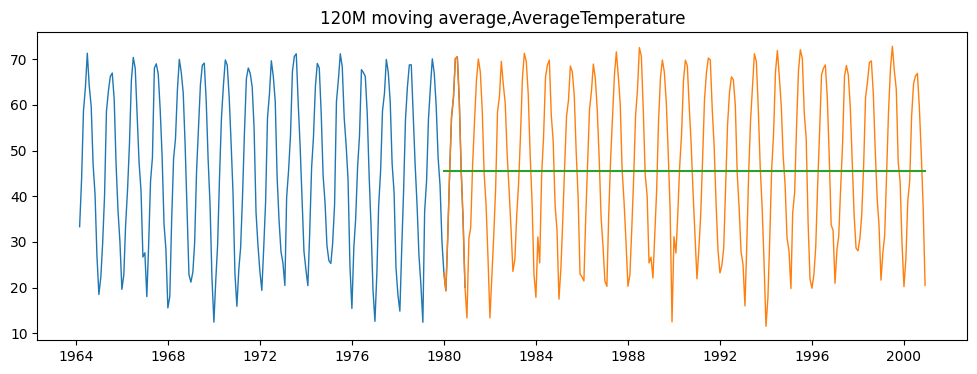

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_62357/1595070935.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.title(f'{eval_df["model_type"][-1:][0]},{target_var}')


AverageTemperature -- RMSE: 17


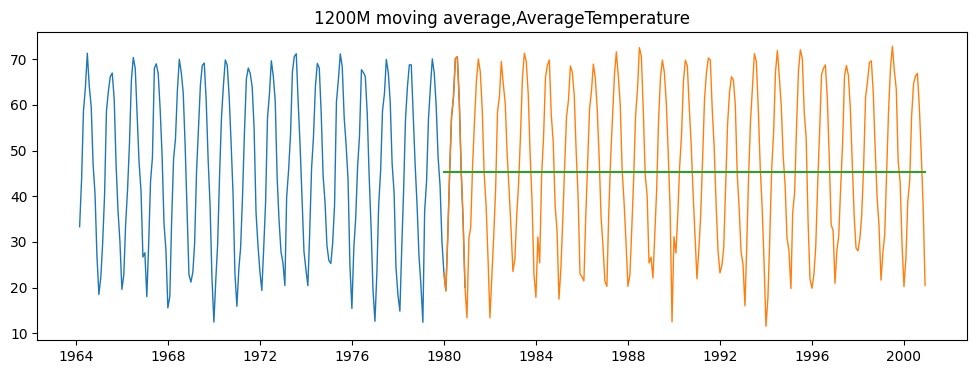

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_62357/1595070935.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.title(f'{eval_df["model_type"][-1:][0]},{target_var}')


AverageTemperature -- RMSE: 31


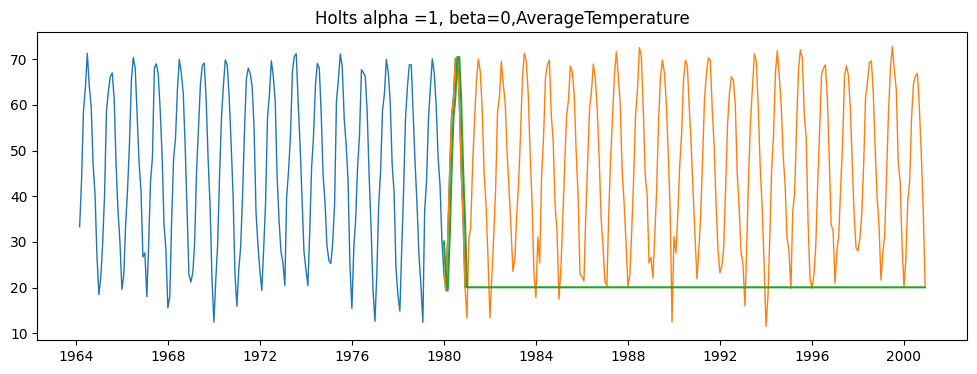

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_62357/1595070935.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.title(f'{eval_df["model_type"][-1:][0]},{target_var}')


AverageTemperature -- RMSE: 5


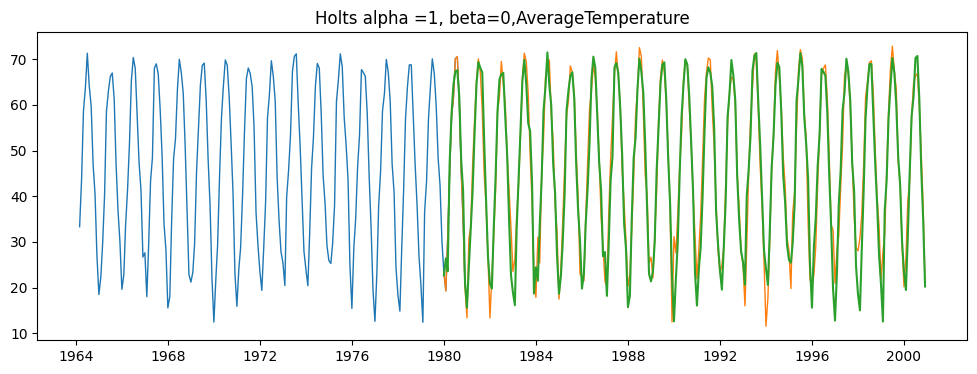

,model_type,target_var,validate_rmse
0,last_observed_value,AverageTemperature,31.0
0,simple_average,AverageTemperature,17.0
0,120M moving average,AverageTemperature,17.0
0,1200M moving average,AverageTemperature,17.0
0,"Holts alpha =1, beta=0",AverageTemperature,31.0
0,Cycle 2 decades,AverageTemperature,5.0


In [14]:
#sets and recleans (to be able to rerun)
train=train0.copy()
train.drop(columns="Decade",inplace=True)
validate.drop(columns="Decade",inplace=True)
test.drop(columns="Decade",inplace=True)


# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'validate_rmse'])

temp = train[target1][-1:][0]

yhat_df = pd.DataFrame({target1: [temp]}, index = validate.index)

#baseline
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)
    plot_and_eval(col)

#simple average
temp = round(train[target1].mean(), 2)

yhat_df = pd.DataFrame({target1: [temp]}, index = validate.index)

for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)
    plot_and_eval(col)


#rolling average
periods = [120,1200]

for p in periods:
    temp = round(train[target1].rolling(p).mean().iloc[-1], 2)

    yhat_df = pd.DataFrame({target1: [temp]}, index = validate.index)

    model_type = str(p) + 'M moving average'
    eval_df = append_eval_df(model_type = model_type,target_var = target1)
    plot_and_eval(col)

#Holt:

#exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
#fit:
#smoothing_level (α): value between (0,1)
#smoothing_slope (β): value between (0,1)
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = 1, smoothing_trend = 0, optimized = True)
    yhat_temp = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_temp, 2)
    eval_df = append_eval_df(model_type = f'Holts alpha =1, beta=0', target_var = col)
    plot_and_eval(target_var = col)

#predict on cycle
train1 = train[:"1980"]

yhat_df = train1.loc['1960':'1980'] + train1[240:].diff(240).mean()
pd.concat([yhat_df.head(1), validate.head(1)])

yhat_df.index = validate.index

len(yhat_df)

for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'Cycle 2 decades', target_var = col)

eval_df

Best model was using the previous 2 decades to predict 

### Takeaways
* last observed value was pretty bad likely due to picking a date with lowest temp in the year
-----------
* simple/and moving average both have same value, this is likely due to the highly cyclical data not producing much insight for a static trend (centers better than last observed)
-----------
* holts used 1 for alpha and 0 for beta, this gave me a great prediction 1 year out, and horrible for the rest
-----------
* previous 2 decades for cycle gave the best rmse at a swing of 5, will be using this moving forward
-----------

## Test
* Best Performing Model:
    - Cycle (2 decades) 
    - Added mean change over the last 2 decades to capture general trend

AverageTemperature -- RMSE: 4


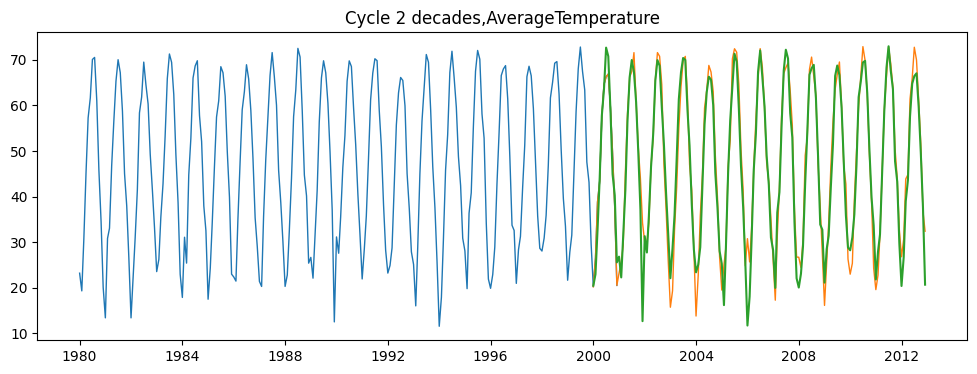

,model_type,target1,test_rmse
0,2 decade cycle,AverageTemperature,4.0


In [15]:
test_eval_df = pd.DataFrame(columns=['model_type', 'target1', 'test_rmse'])

#predict on cycle
train1 = train[:"1980"]

yhat_df = validate[-(len(test.index)):] + train1[240:].diff(240).mean()
pd.concat([yhat_df.head(1), test.head(1)])

yhat_df.index = test.index


for col in train.columns:

    plt.figure(figsize = (12,4))
    plt.plot(validate[target1], label = 'Train+Validate', linewidth = 1)
    plt.plot(test[target1], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target1])
    plt.title(f'Cycle 2 decades,{target1}')
    rmse = round((mean_squared_error(test[target1], yhat_df[target1]))**.5, 0)
    print(target1, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

    test_eval_df.loc[len(test_eval_df.index)] =["2 decade cycle",target1,rmse]


test_eval_df

# Conclusion

## Summary of Key Findings
* Using a model that adds a trend to the previous cycles produced the lowest RMSE
* Using static numbers to predict cycles is not very beneficial
* Temperatures over the last 200 years have not changes much
    * Best model utilized cycle + 20yr mean
* Model gain on predictive performance vs. baseline prediction was high beneficial
    * Baseline RMSE: 17
    * Model RMSE: 5 (4 on test!) (Lower is better) 

## Suggestions and Next Steps
* Isolate year cycles to predict colder/hotter years 
* Model a "normal" year and use that plus the mean of the last years to predict years moving forward
* Add features that would help indicate better and worse years
* Utilize regression to predict based on month instead of rolling cycle
* Understand stakeholder's requirements to target data driven results better